In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

## Preprocessing

### 1. Load Dataset


In [3]:
data = pd.read_csv('./data/data_FPT_thermo.csv')  
data.head(3)

,name,SMILES,FPT_exp_K,MW,1,2,3,4,5,6,...,32,33,34,35,36,37,38,39,40,41
0,1-acetyloxyethyl acetate,CC(=O)OC(C)OC(C)=O,339.04286,146.057909,3.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
1,N-methylcyclohexanamine,CNC1CCCCC1,308.15000,113.120449,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
2,methylsulfanylbenzene,CSc1ccccc1,345.15000,124.034671,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0


In [4]:
X = data.iloc[:, 3:].values
y = data.iloc[:, 2].values

### 2. Train-Test Split (80% Train, 20% Test)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Normalization using MinMaxScaler (-1 to 1)


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 4. Build Neural Network Model

In [7]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(42,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

### 5. 5-Fold Cross-Validation

In [8]:
kf = KFold(n_splits=5)
mse_scores = []
mae_scores = []
fold = 1

for train_index, val_index in kf.split(X_train):
    print(f"Training fold {fold}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = create_model()
    
    # Train the model
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate the model on validation data
    y_val_pred = model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    fold += 1



Training fold 1
5/5 [==============================] - 0s 124us/step
Training fold 2
5/5 [==============================] - 0s 4ms/step
Training fold 3
5/5 [==============================] - 0s 4ms/step
Training fold 4
5/5 [==============================] - 0s 1ms/step
Training fold 5
5/5 [==============================] - 0s 0s/step


#### Calculate average MSE and MAE across folds

In [9]:
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Average MSE across folds: {avg_mse}")
print(f"Average MAE across folds: {avg_mae}")

Average MSE across folds: 1118.243945206777
Average MAE across folds: 21.42447691071765


### 6. Final Evaluation on Training and Test Data


In [10]:
model = create_model()
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

#### Predict on Training Data

In [11]:
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print(f"Training MSE: {train_mse}")
print(f"Training MAE: {train_mae}")

24/24 [==============================] - 0s 679us/step
Training MSE: 757.9118621526274
Training MAE: 17.082575611269018


#### Predict on Test Data


In [12]:

y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

6/6 [==============================] - 0s 0s/step
Test MSE: 741.6943242870154
Test MAE: 19.36982743739063


### 7. Plot Real vs Predicted values and Regression Line with Seaborn

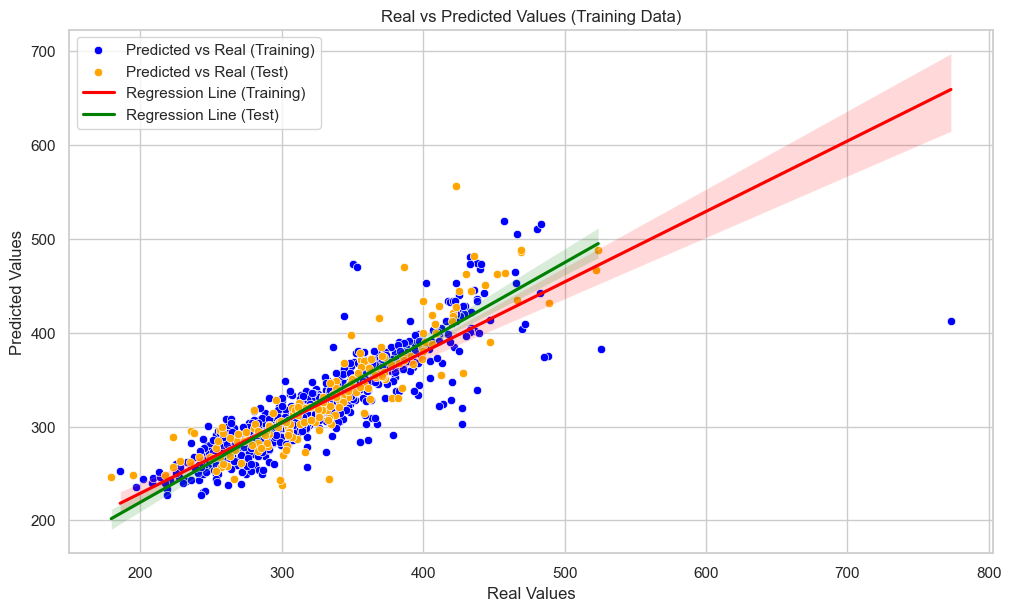

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')

# Scatter plot for training and test data
sns.scatterplot(x=y_train, y=y_train_pred.flatten(), color='blue', label='Predicted vs Real (Training)', ax=ax)
sns.scatterplot(x=y_test, y=y_test_pred.flatten(), color='orange', label='Predicted vs Real (Test)', ax=ax)

# Draw the regression lines
sns.regplot(x=y_train, y=y_train_pred.flatten(), scatter=False, color='red', label='Regression Line (Training)',ax=ax)
sns.regplot(x=y_test, y=y_test_pred.flatten(), scatter=False, color='green', label='Regression Line (Test)', ax=ax)

ax.set_xlabel('Real Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Real vs Predicted Values (Training Data)')
ax.legend()
plt.show()